##### This jupyter notebooks is analyze which transcription factors or miRNAs that regulate the expression of genes using a Lasso regression model
##### Date: Mar 11, 2024

In [30]:
#import libraries
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import r2_score
import numpy as np


In [2]:
Data_dir = "/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/"

In [5]:
# Gene expression data (Gene Counts RPKM) were downloaded from the supplmentary data of the BeatAML paper for wave 1/2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6280667/
GE = pd.read_csv(Data_dir+"/RPKM.csv",index_col = "Unnamed: 0")
GE.index = GE['Gene']
print(GE.shape)

(22843, 453)


In [7]:
#gene id mapping
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]
    
# full gene list and sample list
gene_list = (list(GE.index))
sample_list = list(set(GE.columns) - set(['Gene','Symbol']))

# Formated input gene expression matrix
input_data = GE.loc[list(gene_list), sample_list]

In [8]:
input_data.shape

(22843, 451)

In [9]:
def Filter_low_Expr(arr):
    '''
    Usage: This function is uded to filter out genes which has expression value logRPKM smaller than 0 in more than 50% of the samples.
    Parameter: arr, expression of one gene across different samples
    '''
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)

In [10]:
# Filter genes and scale the data

scaled_df = pd.DataFrame()
array_list = list()
length = input_data.shape[0]
gene_list_remain = []
for i in range(0,length):
    gene = gene_list[i]
    arr = input_data.iloc[i,:]
    if Filter_low_Expr(arr):
        array_mean = np.mean(arr)
        array_std = np.std(arr)
        array_scale = (arr - array_mean)/array_std
        array_list.append(array_scale.values)
        gene_list_remain.append(gene)
#cur_df = pd.DataFrame({gene: array_scale})
#scaled_df = pd.concat([scaled_df, cur_df], axis =1 )
    
scaled_df = pd.DataFrame(array_list)
scaled_df.columns = sample_list
scaled_df.index = gene_list_remain

In [14]:
# Load the transcription factor and target gene pairs

'''
Citation:
Garcia-Alonso, L., Holland, C. H., Ibrahim, M. M., Turei, D. & Saez-Rodriguez, J. 
Benchmark and integration of resources for the estimation of human transcription factor activities. 
Genome Res 29, 1363-1375, doi:10.1101/gr.240663.118 (2019).
'''

TFs = pd.read_csv("~/Documents/GitHub_project/fastqpi_BigGIM/KGs/TFs/database.csv") # source from doi:10.1101/gr.240663.118 (2019)
TFs_sele = TFs.loc[TFs['score'].isin(['A','B','C','D','E'])]

In [17]:
# the source of the miRNA target gene pairs are from MSigDBv7.4 and miRTarbase
'''Huang, H. Y., Lin, Y. C., Cui, S., Huang, Y., Tang, Y., Xu, J., Bao, J., Li, Y., Wen, J., 
Zuo, H., Wang, W., Li, J., Ni, J., Ruan, Y., Li, L., Chen, Y., 
Xie, Y., Zhu, Z., Cai, X., Chen, X., … Huang, H. D. (2022). 
miRTarBase update 2022: an informative resource for experimentally validated miRNA-target interactions. 
Nucleic acids research, 50(D1), D222–D230. https://doi.org/10.1093/nar/gkab1079'''

'''
Liberzon, A. et al. 
Molecular signatures database (MSigDB) 3.0. Bioinformatics 27, 1739-1740, 
doi:10.1093/bioinformatics/btr260 (2011).
'''
miRNA_tar_KG = pd.read_csv("./Data/KG_miRNA_target_edges.csv") # source from miRTarBase and MSigDB

        

In [24]:
#Only 50 microRNAs are included in the Beat AML dataset
miRNA_list = list(set(miRNA_tar_KG['Subject']).intersection(set(GE['Symbol'])))
miRNA_tar_KG_sub = miRNA_tar_KG.loc[miRNA_tar_KG['Subject'].isin(miRNA_list)]
miRNA_tar_KG_sub.shape

(10696, 6)

### select regulators for one target gene

In [43]:
result_list = []
count = 0
new_coef = []

coef_list_all = []
target_list = []
regulator_list = []
r2_list_all = []

for sele_gene in gene_list_remain:
    
#for sele_gene in [dic_gene_map['BCL2']]:
    print(sele_gene)
    new_coef = []
    count = count + 1
    if count % 1000 ==0:
        print(count)
    
    #if sele_gene in set(TFs_sele['target']):
    if sele_gene in dic_gene_map:
        sele_TF_curr_gene = list(TFs_sele.loc[TFs_sele['target'] == dic_gene_map[sele_gene]]['TF'])
    
        if sele_gene in sele_TF_curr_gene:
            sele_TF_curr_gene.remove(sele_gene)
    else:
        sele_TF_curr_gene = []
        
    sele_miRNA_curr_gene = list(miRNA_tar_KG_sub.loc[miRNA_tar_KG_sub['Object'] == sele_gene]['Subject'])

    Potential_regulator_list = sele_TF_curr_gene + miRNA_list
    print(len(Potential_regulator_list))
    
    X_regulators_symbol = []
    X_regulators = []
    for i in Potential_regulator_list:
        if i in dic_gene_map:
            if dic_gene_map[i] in  scaled_df.index:
                X_regulators.append(dic_gene_map[i])
                X_regulators_symbol.append(i)

    #print(len(X_regulators_symbol))
    #Y_gene =dic_gene_map[sele_gene]
    Y_gene = sele_gene
    Y = scaled_df.loc[Y_gene,:].values
    X = scaled_df.loc[X_regulators,:]
    X = X.transpose()

    linreg = linear_model.Lasso(alpha=0.1) 
    linreg.fit(X,Y)
    y_pred = linreg.predict(X)

    coef = list(linreg.coef_)
    r2 = r2_score(Y, y_pred)
    new_coef.extend(coef)
    rss = sum((y_pred-Y)**2)
    new_coef.extend([rss])
    new_coef.extend([linreg.intercept_])
    new_coef.extend([r2])

    
    print("R2:" +str(r2))
    print('nonzero coefs: ', sum(linreg.coef_ != 0))
   
    print("MSE:")
    print(np.mean((y_pred - Y)**2))
    
    gene_cur = X_regulators_symbol
    gene_cur.append(sele_gene+"_"+"RSS")
    gene_cur.append(sele_gene+"_"+"intercept_") 
    gene_cur.append(sele_gene+"_"+"R2") 
    
    result_cur = pd.DataFrame({"Regulator":X_regulators_symbol,
                                "coef":new_coef,
                               "target_gene":[sele_gene]*len(new_coef), "R2":[r2]*len(new_coef)})
    
    result_cur = result_cur.loc[result_cur['coef']!=0]
    regulator_list.extend(result_cur['Regulator'].values)
    target_list.extend(result_cur['target_gene'].values)
    coef_list_all.extend( result_cur['coef'].values)
    r2_list_all.extend(result_cur['R2'].values)
    

ENSG00000000419
85
R2:0.2901329070446407
nonzero coefs:  9
MSE:
0.7098670929553593
ENSG00000000457
157
R2:0.5699400113571955
nonzero coefs:  23
MSE:
0.43005998864280454
ENSG00000000460
132
R2:0.5348763895664017
nonzero coefs:  11
MSE:
0.4651236104335982
ENSG00000000938
145
R2:0.7955816238095113
nonzero coefs:  17
MSE:
0.20441837619048878
ENSG00000000971
99
R2:0.21945288012152664
nonzero coefs:  11
MSE:
0.7805471198784734
ENSG00000001036
93
R2:0.49952038938520515
nonzero coefs:  17
MSE:
0.5004796106147948
ENSG00000001084
127
R2:0.34842098110088127
nonzero coefs:  13
MSE:
0.6515790188991188
ENSG00000001167
120
R2:0.99
nonzero coefs:  1
MSE:
0.010000000000000016
ENSG00000001460
125
R2:0.6388539087292295
nonzero coefs:  17
MSE:
0.3611460912707705
ENSG00000001461
100
R2:0.643925091610819
nonzero coefs:  14
MSE:
0.3560749083891808
ENSG00000001497
115
R2:0.6664982275943505
nonzero coefs:  11
MSE:
0.3335017724056496
ENSG00000001561
80
R2:0.24217454410794426
nonzero coefs:  11
MSE:
0.7578254558

In [44]:
result_df = pd.DataFrame({"Target_gene":target_list, "Regulator":regulator_list, "Coef": coef_list_all, 'R2':r2_list_all})

(array([2.300e+01, 5.800e+01, 5.100e+01, 1.290e+02, 2.200e+02, 2.350e+02,
        2.680e+02, 2.930e+02, 4.090e+02, 4.770e+02, 5.460e+02, 6.470e+02,
        8.090e+02, 9.270e+02, 9.870e+02, 1.176e+03, 1.336e+03, 1.466e+03,
        1.390e+03, 1.890e+03, 1.775e+03, 2.258e+03, 2.344e+03, 2.691e+03,
        2.772e+03, 3.169e+03, 3.383e+03, 3.711e+03, 3.557e+03, 3.435e+03,
        3.987e+03, 4.598e+03, 5.021e+03, 5.380e+03, 5.413e+03, 4.903e+03,
        5.543e+03, 5.728e+03, 5.950e+03, 5.609e+03, 5.927e+03, 6.072e+03,
        6.454e+03, 6.218e+03, 5.646e+03, 6.343e+03, 6.294e+03, 6.087e+03,
        6.824e+03, 5.915e+03, 6.716e+03, 7.083e+03, 6.936e+03, 6.211e+03,
        5.819e+03, 6.025e+03, 5.719e+03, 6.092e+03, 5.460e+03, 5.642e+03,
        5.504e+03, 5.336e+03, 5.216e+03, 4.378e+03, 4.838e+03, 4.246e+03,
        4.553e+03, 4.420e+03, 4.133e+03, 3.652e+03, 2.929e+03, 3.173e+03,
        2.947e+03, 2.640e+03, 2.450e+03, 2.488e+03, 2.197e+03, 1.829e+03,
        1.802e+03, 1.436e+03, 1.073e+0

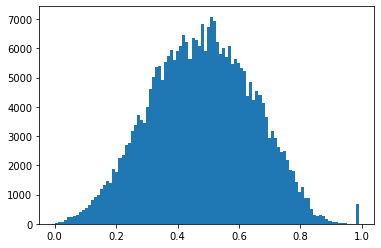

In [48]:
# hist of R2
import matplotlib.pyplot as plt
plt.hist(result_df['R2'], bins = 100)


In [246]:
#result_df.to_csv("KG_regulatory_graph_Mar1_2023.csv")

In [49]:
# Add gene symbol
Symbol_list = []
for gene in list(result_df['Target_gene']):
    if gene in dic_gene_map:
        Symbol_list.append(dic_gene_map[gene])
    else:
        Symbol_list.append(gene)
        
result_df['Target_symbol'] = Symbol_list
result_df
result_df.to_csv("./Data/KG_regulatory_graph_Mar11_2024.csv")
#This is related to the Supplementary table 2 in the paper.

,Target_gene,Regulator,Coef,R2,Target_symbol
0,ENSG00000000419,CDC5L,1.701594e-01,0.290133,DPM1
1,ENSG00000000419,GMEB2,2.731186e-02,0.290133,DPM1
2,ENSG00000000419,LYAR,1.412380e-02,0.290133,DPM1
3,ENSG00000000419,NFE2L2,8.039387e-02,0.290133,DPM1
4,ENSG00000000419,PHF5A,2.317660e-01,0.290133,DPM1
...,...,...,...,...,...
295131,ENSG00000273488,MIR4461,2.068118e-02,0.402348,RP11-114I8.4
295132,ENSG00000273488,MIR4258,2.468892e-02,0.402348,RP11-114I8.4
295133,ENSG00000273488,ENSG00000273488_RSS,2.695412e+02,0.402348,RP11-114I8.4
295134,ENSG00000273488,ENSG00000273488_intercept_,3.476272e-16,0.402348,RP11-114I8.4


# End